**If Possible, use 32 but image. It works better**

In [1]:
from skimage import io

In [417]:
img_test = io.imread('/content/drive/MyDrive/N2V_Inputs/SARA_WT/C1-mut17_set1.tif')

In [373]:
print(img_test.shape)

(43, 512, 512)


In [289]:
def z_slicer(img):
    list_z = []
    z_len = img.shape[0]
    for i in range(z_len):
        img_selected = img[i, :, :]
        list_z.append(img_selected)
    return list_z

In [409]:
z_slicer(img_test)

[array([[20,  9,  7, ..., 30, 22, 15],
        [14, 15, 65, ...,  7, 14, 56],
        [ 9, 48, 13, ..., 28,  5, 59],
        ...,
        [47, 39, 38, ..., 11, 17, 10],
        [ 4, 16, 16, ..., 63, 11, 59],
        [10, 19, 54, ...,  6, 18, 12]], dtype=uint16),
 array([[27, 42, 67, ..., 32, 33, 21],
        [84, 10,  7, ..., 10, 20, 28],
        [20,  6, 41, ...,  6, 81, 57],
        ...,
        [ 9, 16, 32, ..., 50, 19, 13],
        [ 7, 11, 16, ..., 25, 76, 16],
        [25, 10, 18, ..., 40, 13, 49]], dtype=uint16),
 array([[175,  82, 111, ...,  69,  17,  20],
        [ 70,   7,   7, ...,  25,  18,  33],
        [ 83,  92,  43, ...,  26,  26,   2],
        ...,
        [  6,  45,  21, ...,  11,  69,  59],
        [ 78,  19,  14, ...,   7,   8,   8],
        [ 41,  58,  30, ...,  45,  77,   8]], dtype=uint16),
 array([[229,  76,  34, ..., 139, 130,  21],
        [170, 112,  59, ...,  54,  66,  19],
        [112, 121,  60, ...,  41, 149,  22],
        ...,
        [ 84,  69, 156, ...

In [418]:
img_list = z_slicer(img_test)

In [292]:
type(img_list)


list

In [385]:
len(img_list)

35

**2D N2V demoising**

In [294]:
#Install the tensorflow library suggested by N2V.
!pip install tensorflow==2.4

ERROR: Could not find a version that satisfies the requirement tensorflow==2.4 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0)
ERROR: No matching distribution found for tensorflow==2.4


In [295]:
!pip install n2v

In [296]:
import tensorflow as tf
import n2v
print(tf.__version__)
print(n2v.__version__)

2.12.0
0.3.2


In [297]:
# We import all our dependencies.
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
import zipfile

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [298]:
# We create our DataGenerator-object.
# It will help us load data and extract patches for training and validation.
datagen = N2V_DataGenerator()

In [299]:
#METHOD 1: Loading images using load_imgs_from_directory method
# We load all the '.png' files from the directory.
# The function will return a list of images (numpy arrays).
imgs = datagen.load_imgs_from_directory(directory = "/content/drive/MyDrive/N2V_training",
                                        dims='YX')  #ZYX for 3D

# Let's look at the shape of the image
print('shape of loaded images: ',imgs[0].shape)
# If the image has four color channels (stored in the last dimension): RGB and Aplha.
# We are not interested in Alpha and will get rid of it.
imgs[0] = imgs[0][...,:3]
print('shape without alpha:    ',imgs[0].shape)
print('The data type of the first image is: ', imgs[0].dtype)

shape of loaded images:  (1, 512, 512, 1)
shape without alpha:     (1, 512, 512, 1)
The data type of the first image is:  float32


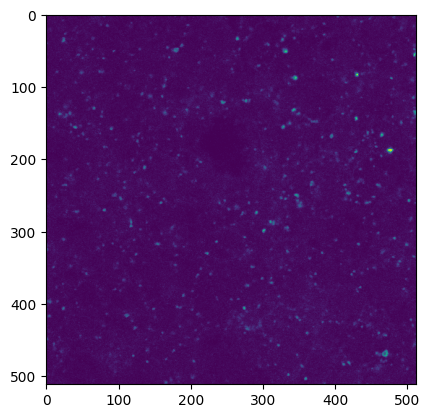

In [300]:
# Let's look at the image.
plt.figure()
plt.imshow(imgs[0][0,:,:,:])
plt.show()

In [301]:
patch_size = 64

In [302]:
# Patches are extracted from all images and combined into a single numpy array
patch_shape = (patch_size,patch_size)
patches = datagen.generate_patches_from_list(imgs, shape=patch_shape)


Generated patches: (512, 64, 64, 1)


In [303]:
patches.shape

(512, 64, 64, 1)

In [304]:
# Patches are created so they do not overlap.
# (Note: this is not the case if you specify a number of patches. See the docstring for details!)
# Non-overlapping patches enable us to split them into a training and validation set.
train_val_split = int(patches.shape[0] * 0.8)
X = patches[:train_val_split]
X_val = patches[train_val_split:]

In [305]:
print(X.shape)
print(X.dtype)
print(X_val.shape)

(409, 64, 64, 1)
float32
(103, 64, 64, 1)


In [306]:
# Just in case you don't know how to access the docstring of a method:
datagen.generate_patches_from_list?

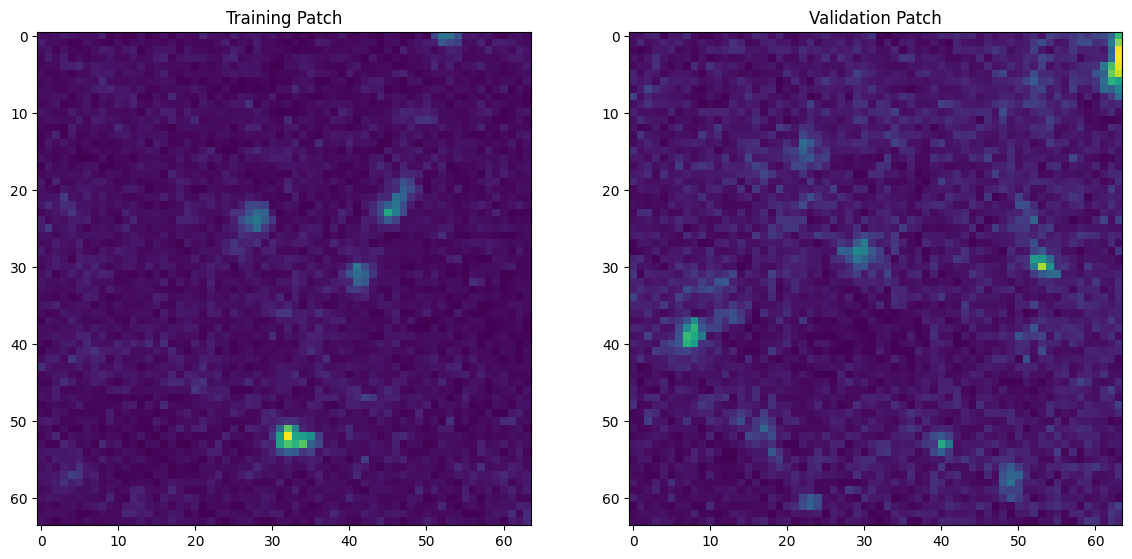

In [307]:
# Let's look at two patches.
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[0,...])
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[0,...])
plt.title('Validation Patch');

In [308]:
# train_steps_per_epoch is set to (number of training patches)/(batch size), like this each training patch
# is shown once per epoch.
train_batch = 32
config = N2VConfig(X, unet_kern_size=3,
                   unet_n_first=64, unet_n_depth=3, train_steps_per_epoch=int(X.shape[0]/train_batch), train_epochs=20, train_loss='mse',
                   batch_norm=True, train_batch_size=train_batch, n2v_perc_pix=0.198, n2v_patch_shape=(patch_size, patch_size),
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5, single_net_per_channel=False)


# Let's look at the parameters stored in the config-object.
vars(config)

{'means': ['8.034372'],
 'stds': ['8.67452'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'unet_residual': False,
 'unet_n_depth': 3,
 'unet_kern_size': 3,
 'unet_n_first': 64,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'mse',
 'train_epochs': 20,
 'train_steps_per_epoch': 12,
 'train_learning_rate': 0.0004,
 'train_batch_size': 32,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 0.198,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'single_net_per_channel': False,
 'blurpool': False,
 'skip_skipone': False,
 'structN2Vmask': None,
 'probabilistic': False}

In [309]:
# a name used to identify the model --> change this to something sensible!
model_name = 'n2v_2D_stars'
# the base directory in which our model will live
basedir = 'models'
# We are now creating our network model.
model = N2V(config, model_name, basedir=basedir)

In [310]:
# We are ready to start training now.
history = model.train(X, X_val)

8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 103/103 [00:00<00:00, 2321.67it/s]

Epoch 1/20


12/12 [==============================] - 116s 9s/step - loss: 1.1965 - n2v_mse: 1.1965 - n2v_abs: 0.6449 - val_loss: 0.6059 - val_n2v_mse: 0.9451 - val_n2v_abs: 0.4888 - lr: 4.0000e-04
Epoch 2/20
12/12 [==============================] - 106s 9s/step - loss: 0.4080 - n2v_mse: 0.4080 - n2v_abs: 0.4627 - val_loss: 0.5318 - val_n2v_mse: 0.8156 - val_n2v_abs: 0.4527 - lr: 4.0000e-04
Epoch 3/20
12/12 [==============================] - 108s 9s/step - loss: 0.4149 - n2v_mse: 0.4149 - n2v_abs: 0.4307 - val_loss: 0.5164 - val_n2v_mse: 0.7708 - val_n2v_abs: 0.4402 - lr: 4.0000e-04
Epoch 4/20
12/12 [==============================] - 106s 9s/step - loss: 0.3273 - n2v_mse: 0.3273 - n2v_abs: 0.4119 - val_loss: 0.5337 - val_n2v_mse: 0.8033 - val_n2v_abs: 0.4480 - lr: 4.0000e-04
Epoch 5/20
12/12 [==============================] - 109s 9s/step - loss: 0.3364 - n2v_mse: 0.3364 - n2v_abs: 0.4003 - val_loss: 0.4743 - val_n2v_mse: 0.6823 - val_n2v_abs: 0.4348 - lr: 4.0000e-04
Epoch 6/20
12/12 [=============

['loss', 'lr', 'n2v_abs', 'n2v_mse', 'val_loss', 'val_n2v_abs', 'val_n2v_mse']


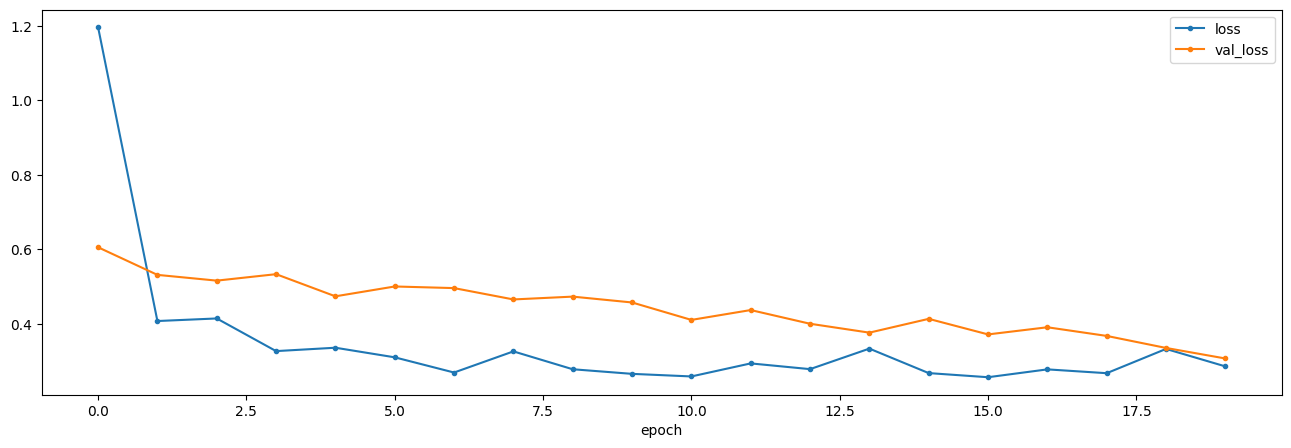

In [311]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

In [312]:
# We import all our dependencies.
from n2v.models import N2V
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.image import imread, imsave
from csbdeep.io import save_tiff_imagej_compatible

In [313]:
# A previously trained model is loaded by creating a new N2V-object without providing a 'config'.
model_name = 'n2v_2D_stars'
basedir = 'models'
model = N2V(config=None, name=model_name, basedir=basedir)

Loading network weights from 'weights_best.h5'.


In [314]:
pred = model.predict(img_list[20], axes='YX')

The input image is of type uint16 and will be casted to float32 for prediction.
1/1 [==============================] - 5s 5s/step


In [315]:
pred.shape

(512, 512)

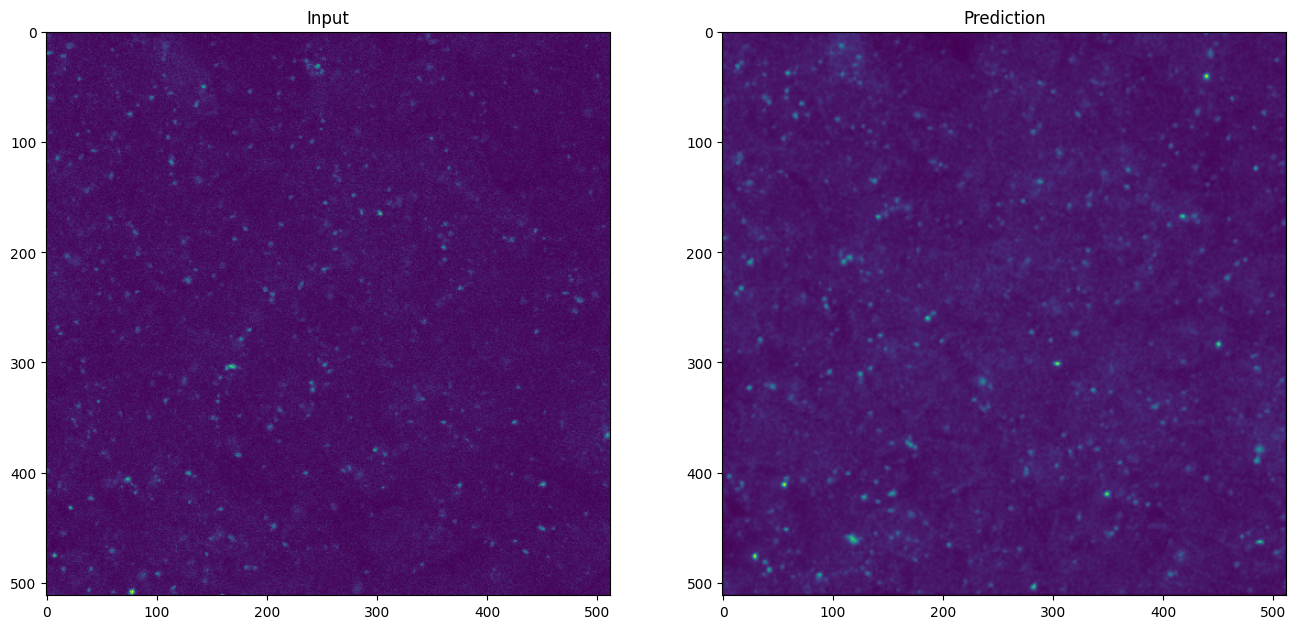

In [316]:
# Let's look at the results.
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(img_list[25])
plt.title('Input');
plt.subplot(1,2,2)
plt.imshow(pred)
plt.title('Prediction');

In [317]:
def pred_list (in_list):
  out_list = []
  for i in range(len(in_list)-1):
    y = model.predict(in_list[i], axes = 'YX')
    out_list.append(y)
  return(out_list)

In [419]:
output_image_list = pred_list(img_list)

The input image is of type uint16 and will be casted to float32 for prediction.
1/1 [==============================] - 6s 6s/step
The input image is of type uint16 and will be casted to float32 for prediction.
1/1 [==============================] - 4s 4s/step
The input image is of type uint16 and will be casted to float32 for prediction.
1/1 [==============================] - 4s 4s/step
The input image is of type uint16 and will be casted to float32 for prediction.
1/1 [==============================] - 5s 5s/step
The input image is of type uint16 and will be casted to float32 for prediction.
1/1 [==============================] - 4s 4s/step
The input image is of type uint16 and will be casted to float32 for prediction.
1/1 [==============================] - 4s 4s/step
The input image is of type uint16 and will be casted to float32 for prediction.
1/1 [==============================] - 4s 4s/step
The input image is of type uint16 and will be casted to float32 for prediction.
1/1 [=====

In [319]:
len(output_image_list)

46

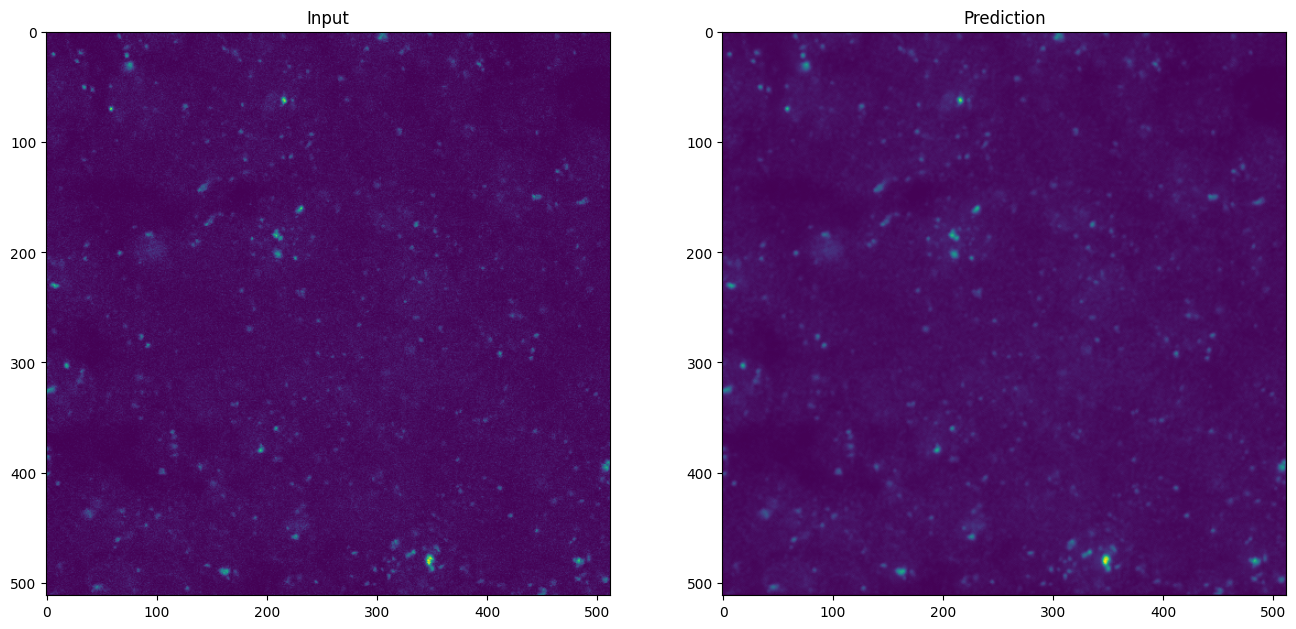

In [333]:
# Let's look at the results.
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(img_list[12])
plt.title('Input');
plt.subplot(1,2,2)
plt.imshow(output_image_list[12])
plt.title('Prediction');

In [420]:
stacked_3d_image = np.stack(output_image_list, axis=0)


In [421]:
print(stacked_3d_image.shape)

(59, 512, 512)


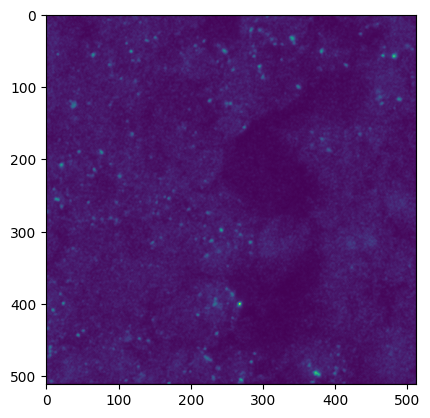

In [370]:
plt.imshow(stacked_3d_image[20,:,:])

In [413]:
stacked_3d_image.dtype

dtype('float32')

In [422]:
normalized_array = (stacked_3d_image - stacked_3d_image.min()) / (stacked_3d_image.max() - stacked_3d_image.min())
scaled_array = (normalized_array * 255.0)
arr_uint8 = scaled_array.astype(np.uint8)
img_downscaled_8bit = arr_uint8

In [423]:
img_downscaled_8bit.dtype

dtype('uint8')

In [327]:
from tifffile import imsave, imwrite


In [424]:
metadata={'spacing': 0.57 , 'unit': 'um', 'axes': 'ZYX'}
imwrite("/content/drive/MyDrive/SARA_Mutant17.tiff", img_downscaled_8bit, imagej=True,
        resolution=(1./0.2, 1./0.2), metadata=metadata)

**Cellpose part**

In [ ]:
!pip install "opencv-python-headless<4.3"
!pip install cellpose
!pip install pyclesperanto-prototype


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 MB 12.9 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.0.74
    Uninstalling opencv-python-headless-4.8.0.74:
      Successfully uninstalled opencv-python-headless-4.8.0.74
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 1.2.1 requires opencv-python-headless>=4.1.1, but you have opencv-python-headless 3.4.18.65 which is incompatible.
qudida 0.0.4 requires opencv-python-headless>=4.0.1, but you have opencv-python-headless 3.4.18.65 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.7/171.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 617.9/617.9 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import skimage.io
import matplotlib.pyplot as plt
import matplotlib as mpl
import pyclesperanto_prototype as cle
from skimage import filters
from skimage.transform import rescale


%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

from urllib.parse import urlparse
from cellpose import models, core

use_GPU = core.use_gpu()
print('>>> GPU activated? %d'%use_GPU)

# call logger_setup to have output of cellpose written
from cellpose.io import logger_setup
logger_setup();

>>> GPU activated? 0
creating new log file


In [ ]:
from cellpose import utils


In [ ]:
from cellpose import models

# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'

model = models.Cellpose(gpu=use_GPU, model_type='cyto')

# model = models.Cellpose(gpu=use_GPU, model_type='nuclei')

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
# channels = [0,0]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

# or if you have different types of channels in each image
channels = [0,0]
# channels = [1,1]

# 1. computes flows from 2D slices and combines into 3D flows to create masks
print('running cellpose 2D slice flows => masks')


masks, flows, styles, _ = model.eval(img_downscaled_8bit, channels=[0,0], diameter=35,flow_threshold=0.9, do_3D=True)

100%|██████████| 25.3M/25.3M [00:00<00:00, 28.9MB/s]
100%|██████████| 5.23k/5.23k [00:00<00:00, 2.42MB/s]


running cellpose 2D slice flows => masks


In [ ]:
diams = 35

In [ ]:
from cellpose import io

io.masks_flows_to_seg(img_downscaled_8bit,
                      masks,
                      flows,
                      diams,
                      file_names='/content/drive/MyDrive/Cellpose_Test/N2V_segments_seg.npy',
                      channels=[0, 0])